# SU(2) Montecarlo lattice simulation

 Using Monte Carlo techniques, we evaluate path integrals for pure SU(2) gauge fields. Wilson's regularization procedure on a lattice of up to $10^4$ sites controls ultraviolet divergences. Our renormalization prescription, based on confinement, is to hold fixed the string tension, the coefficient of the asymptotic linear potential between sources in the fundamental representation of the gauge group. Upon reducing the cutoff, we observe a logarithmic decrease of the bare coupling constant in a manner consistent with the perturbative renormalization-group prediction. This supports the coexistence of confinement and asymptotic freedom for quantized non-Abelian gauge fields.

# Libraries

In [ ]:
#### Definition of the libraries ####
import numpy as np
import matplotlib.pyplot as plt

# Library for the creation of the tables
from tabulate import tabulate

from scipy.optimize import curve_fit


import time



# Global variables

In [ ]:
# Function for organizing the plot
def wall():
  print('\n')
  print('#' * 100)
  print('\n')


## Montecarlo Methods

### Initialization

In [ ]:
# Functio to initialize the lattice: Cold state or Hot Bath
def initialize_lattice(L,state):
      if state == 'Cold':
          U = {mu: np.array([[[[np.eye(2, dtype=complex) for _ in range(L)] for _ in range(L)] for _ in range(L)] for _ in range(L)])
                for mu in range(4)}


      else:
        U={ mu: np.array([[[[Hot_Initialization() for _ in range(L)] for _ in range(L)] for _ in range(L)]for _ in range(L)])
                for mu in range(4)}

      return U



# Functio to initialize the lattice in the Hot Bath
def Hot_Initialization():
  # Define the SU(2) group generators
    sigma1 = np.array([[0, 1], [1, 0]], dtype=complex)  # Pauli matrix σ1
    sigma2 = np.array([[0, -1j], [1j, 0]], dtype=complex)  # Pauli matrix σ2
    sigma3 = np.array([[1, 0], [0, -1]], dtype=complex)  # Pauli matrix σ3
    identity = np.eye(2, dtype=complex)

    a_0 = np.random.rand()
    a_1 = np.random.rand()
    a_2 = np.random.rand()
    a_3 = np.random.rand()

    norm=(a_0**2+a_1**2+a_2**2+a_3**2)**(0.5)

    a_0=a_0/norm
    a_1= 1j*a_1/norm
    a_2=1j*a_2/norm
    a_3=1j*a_3/norm

    # Construct the SU(2) matrix using Euler angles
    return ( a_0 * identity + a_1 * sigma1 + a_2 * sigma2 + a_3 * sigma3)




### Montecarlo update

In [ ]:
# Function to upgrade the lattice
def montecarlo_upgrade_lattice(U,L,beta,w_loop):
    #start_time = time.time()
    for mu in range(4):
      for t in range(L):
          for z in range(L):
              for y in range(L):
                  for x in range(L):
                      U[mu][x, y, z, t] = generate_random_su2(U, x, y, z, t, mu, L, beta)


    #end_time = time.time()
    #elapsed_time = end_time - start_time
    #print(f"Elapsed time: {elapsed_time} seconds for upgrading the lattice")
    loop_sizes = range(1,6) #if w_loop == "All" else [int(w_loop)]

    loop_values, wilson_values,plaquette_values = [], [],[]

    # Save all the infos in a dictionary
    wilson =[]

    for loop_size in loop_sizes:
        w_value = wilson_loop(U, loop_size,L)

        wilson_values.append(w_value)
        loop_values.append(loop_size)

    wilson={
        'loop_size': loop_values,
        'wilson_values': wilson_values
    }


    return U,wilson


# Function to avoid (decrease) errors due to the approximation
def enforce_unitarity(U):
    """
    Enforce unitarity of a 2x2 matrix by re-projecting it onto the SU(2) group.

    Parameters:
        U: 2x2 complex matrix.

    Returns:
        U_projected: The re-projected unitary SU(2) matrix.
    """
    # Perform SVD (Singular Value Decomposition)
    U, s, Vh = np.linalg.svd(U)

    # Reconstruct the matrix to be unitary (force singular values to 1)
    U_projected = U @ Vh

    # Enforce determinant to be exactly 1
    det = np.linalg.det(U_projected)
    U_projected /= det**(1/2)

    # Rounding to mitigate floating-point errors
    U_projected = np.round(U_projected, decimals=20)

    return U_projected

### Forward and backward function

In [ ]:
# Forward and backward indices for mu and nu directions
def forward(coord, direction, L):
    """Move forward in the given direction."""
    x, y, z, t = coord  # Unpack coordinates
    if direction == 0:  # x-direction
        return ((x + 1) % L, y, z, t)
    elif direction == 1:  # y-direction
        return (x, (y + 1) % L, z, t)
    elif direction == 2:  # z-direction
        return (x, y, (z + 1) % L, t)
    elif direction == 3:  # t-direction
        return (x, y, z, (t + 1) % L)

def backward(coord, direction, L):
    """Move backward in the given direction."""
    x, y, z, t = coord  # Unpack coordinates
    if direction == 0:  # x-direction
        return ((x - 1 + L) % L, y, z, t)
    elif direction == 1:  # y-direction
        return (x, (y - 1 + L) % L, z, t)
    elif direction == 2:  # z-direction
        return (x, y, (z - 1 + L) % L, t)
    elif direction == 3:  # t-direction
        return (x, y, z, (t - 1 + L) % L)

### Upgrade Lattice: K, $U_{bar}$ and $a_0$ generation

In [ ]:
# Function to generate random SU(2) based on the conditions
def generate_random_su2(U,x,y,z,t,mu,L,beta):

    # Define the SU(2) group generators
    sigma1 = np.array([[0, 1], [1, 0]], dtype=complex)  # Pauli matrix σ1
    sigma2 = np.array([[0, -1j], [1j, 0]], dtype=complex)  # Pauli matrix σ2
    sigma3 = np.array([[1, 0], [0, -1]], dtype=complex)  # Pauli matrix σ3
    identity = np.eye(2, dtype=complex)

    # calculation of K
    #start_time = time.time()
    K,U_bar=compute_k(U, x, y, z, t,mu, L)
    #end_time = time.time()
    #elapsed_time = end_time - start_time
    #print(f"Elapsed time: {elapsed_time} seconds for computing K")

    #start_time = time.time()
    a_0=generate_a0(beta*K)
    #end_time = time.time()
    #elapsed_time = end_time - start_time
    #print(f"Elapsed time: {elapsed_time} seconds for computing a_0")

    #start_time = time.time()
    a_mod = (1 - a_0**2)**(0.5)

    theta=np.random.uniform(0,np.pi)
    phi=np.random.uniform(0,2*np.pi)

    a_3= 1j* a_mod*np.cos(theta)
    a_2= 1j* a_mod*np.sin(theta)*np.cos(phi)
    a_1= 1j* a_mod*np.sin(theta)*np.sin(phi)


    # Construct the SU(2) matrix using Euler angles
    U_gen= a_0 * identity + a_1 * sigma1 + a_2 * sigma2 + a_3 * sigma3


    U_element=(U_gen)@(np.linalg.inv(U_bar))
    U_element=enforce_unitarity(U_element)
    #end_time = time.time()
    #elapsed_time = end_time - start_time
    #print(f"Elapsed time: {elapsed_time} seconds for generating random SU(2)")

    return U_element


def compute_k(U, x, y, z, t,mu, L):
    """
    Compute k from the sum of 6 plaquette matrices (staples) interacting with a given link U_mu(x).

    Parameters:
        U: 4D NumPy array of shape (L, L, L, L), where each element is a list of 4 SU(2) matrices.
        x, y, z, t: Coordinates of the starting point.
        mu: Direction of the link variable.
        L: Size of the lattice in each dimension.

    Returns:
        k: The value of k as described in the formula.
        U_bar: The normalized sum of the staples (proportional to an SU(2) matrix).
    """

    U_alpha = np.zeros((2, 2), dtype=complex)  # Accumulator for staple contributions
    #print('coords',x,y,z,t)
    for nu in range(4):  # Iterate over all directions
        if nu == mu:
            continue  # Skip the same direction as mu

        #print('mu,nu',mu,nu)

        # First staple: Positive direction
        nu_x_plus_mu = forward((x, y, z, t), mu, L)  # Move forward in mu
        #print('nu_x_plus_mu',nu_x_plus_mu)
        U_nu_x_plus_mu = U[nu][nu_x_plus_mu]  # Get link in nu direction

        mu_x_plus_nu = forward((x, y, z, t), nu, L)  # Move forward in nu
        #print('mu_x_plus_nu',mu_x_plus_nu)
        U_mu_x_plus_nu = U[mu][mu_x_plus_nu].conj().T  # Hermitian conjugate of mu link

        nu_x = (x, y, z, t)  # No movement (current location)
        #print('nu_x',nu_x)
        U_nu_x = U[nu][nu_x].conj().T  # Hermitian conjugate of nu link

        #wall()

        # Compute the first staple matrix
        U_tilde_pos = U_nu_x_plus_mu @ U_mu_x_plus_nu @ U_nu_x

        # Second staple: Negative direction
        nu_x_minus_nu = backward((x, y, z, t), nu, L)  # Move backward in nu
        #print('nu_x_minus_nu',nu_x_minus_nu)
        U_nu_x_minus_nu = U[nu][nu_x_minus_nu]  # Get link

        mu_x_minus_nu = nu_x_minus_nu  # Move in mu from (x - nu)
        #print('mu_x_minus_nu',mu_x_minus_nu)
        U_mu_x_minus_nu = U[mu][mu_x_minus_nu].conj().T  # Hermitian conjugate of mu link

        nu_x_minus_nu_plus_mu = forward(mu_x_minus_nu, mu, L)  # Move forward in mu
        #print('nu_x_minus_nu_plus_mu',nu_x_minus_nu_plus_mu)
        U_nu_x_minus_nu_plus_mu = U[nu][nu_x_minus_nu_plus_mu].conj().T  # Hermitian conjugate of nu link

        # Compute the second staple matrix
        U_tilde_neg = U_nu_x_minus_nu_plus_mu @ U_mu_x_minus_nu @ U_nu_x_minus_nu

        #print('U_tilde_pos',U_tilde_pos,'\n')
        #print('U_tilde_neg',U_tilde_neg,'\n')

        # Sum contributions
        U_alpha +=  U_tilde_pos + U_tilde_neg
        #print('alpha:',U_alpha)
        #wall()

    # Compute k as the square root of the determinant
    k = (np.abs(np.linalg.det(U_alpha)))**(0.5)

    # Normalize U_alpha to get U_bar
    U_bar = U_alpha / k

    #U_bar = enforce_unitarity(U_bar)

    return k, U_bar


def generate_a0(C):
    """
    Generate a_0 following the probability distribution
    P(a_0) ~ (1 - a_0^2)^{1/2} exp(βKa_0).

    Parameters:
        beta: float - The inverse coupling strength (temperature parameter)
        K: float - Computed staple term

    Returns:
        a_0: float - Sampled value following the correct probability distribution
    """
    exp=np.exp(-2 * C)
    fraction=1/C
    while True:
        # Generate x in the range specified in the article
        x = np.random.uniform(exp, 1)

        # Compute trial a_0
        a_0 = 1 + fraction * np.log(x)

        # Check if a_0 is within bounds
        if -1 <= a_0 <= 1:
            # Compute the correct rejection probability
            rejection_prob = 1 - np.sqrt(1 - a_0**2)

            # Accept or reject based on the rejection probability
            if np.random.uniform(0, 1) > rejection_prob:
                return a_0

### Wilson Loop computation

In [ ]:
def wilson_loop(U, loop_size, L):
    """
    Calculate the Wilson loop for a 4D cubic lattice for a given loop size.

    Parameters:
        U: Dictionary {mu: 4D NumPy array} of SU(2) link variables.
        loop_size: Integer, the size of the Wilson loop.
        L: Integer, lattice size.

    Returns:
        Average Wilson loop value.
    """
    Wilson = []
    # Iterate over all starting points (x, y, z, t)
    for t in range(L):
      for z in range(L):
          for y in range(L):
              for x in range(L):
                  for mu in range(4):
                      for nu in range(mu + 1, 4):

                            # Initialize Wilson loop matrix
                            P = np.eye(2, dtype=complex)
                            coords = (x, y, z, t)

                            # Move forward in mu direction
                            for _ in range(loop_size):
                                P = P @ U[mu][coords]   # Multiply link
                                coords = forward(coords, mu, L)

                            # Move forward in nu direction
                            for _ in range(loop_size):
                                P = P @ U[nu][coords]  # Multiply link
                                coords = forward(coords, nu, L)

                            # Move backward in mu direction (multiply adjoint first)
                            for _ in range(loop_size):
                                coords = backward(coords, mu, L)  # Move back
                                P = P @ U[mu][coords].conj().T  # Multiply adjoint

                            # Move backward in nu direction (multiply adjoint first)
                            for _ in range(loop_size):
                                coords = backward(coords, nu, L)  # Move back
                                P = P @ U[nu][coords].conj().T  # Multiply adjoint

                            # Compute trace (normalize for SU(2))
                            trace_value = 0.5 * np.real(np.trace(P))
                            Wilson.append(trace_value)

    # Return the average Wilson loop value
    return np.mean(Wilson)


## Main: simple

In [ ]:
# Define the varying beta values and lattice sizes
beta_values = [1.2,1.6,2,2.4,2.8,3.2]     #np.linspace(1.0, 3.0, 10) #[1.2,1.6,2,2.4,2.8,3.2]
lattice_sizes = [8]         # Lattice sizes to simulate
N = 50                                # Number of Monte Carlo sweeps

# Placeholder to store results
results = []
U={}
# Iterate over lattice sizes
for L in lattice_sizes:
    print(f"Starting simulation for lattice size L={L}")
    print('_'*50)
    print('\n')

    # Iterate over beta values
    for beta in beta_values:
        print(f"  Beta: {beta}")
        wall()

        # Initialize the lattice in the 'Cold'/'Hot' state
        U = initialize_lattice(L, state='Hot')

        # Collectors for Plaquette and Wilson values
        plaquette_collector = []
        wilson_collector = []

        # Perform Monte Carlo sweeps
        for sweep in range(1, N + 1):

            start_time = time.time()

            U, wilson = montecarlo_upgrade_lattice(U, L, beta,w_loop='1')

            # Collect the results
            wilson_collector.append(wilson)

            # Optional: Print progress every 10 sweeps
            if sweep % 1 == 0:
                end_time = time.time()
                elapsed_time = end_time - start_time
                print(f"Elapsed time: {elapsed_time} seconds")
                print(f"    Sweep {sweep} completed for Beta={beta}, L={L}")

        print('\n')

        # Store results for this beta and lattice size
        results.append({
            'Lattice_Size': L,
            'Beta': beta,
            'Wilson': wilson_collector,
        })

    print('_'*50)
    print(f"Finished simulation for lattice size L={L}")
    wall()

print("Monte Carlo simulation completed.")


Starting simulation for lattice size L=8
__________________________________________________


  Beta: 1.2


####################################################################################################


Elapsed time: 6.762315273284912 seconds
    Sweep 1 completed for Beta=1.2, L=8
Elapsed time: 7.347044467926025 seconds
    Sweep 2 completed for Beta=1.2, L=8
Elapsed time: 6.760042667388916 seconds
    Sweep 3 completed for Beta=1.2, L=8
Elapsed time: 7.16924786567688 seconds
    Sweep 4 completed for Beta=1.2, L=8
Elapsed time: 6.097471475601196 seconds
    Sweep 5 completed for Beta=1.2, L=8
Elapsed time: 6.452365875244141 seconds
    Sweep 6 completed for Beta=1.2, L=8
Elapsed time: 6.520944356918335 seconds
    Sweep 7 completed for Beta=1.2, L=8
Elapsed time: 6.190519094467163 seconds
    Sweep 8 completed for Beta=1.2, L=8
Elapsed time: 6.178152799606323 seconds
    Sweep 9 completed for Beta=1.2, L=8
Elapsed time: 6.025594472885132 seconds
    Sweep 10 completed for Bet

KeyboardInterrupt: 

### Plaquette and Wilson Loop depending on beta and Loop size

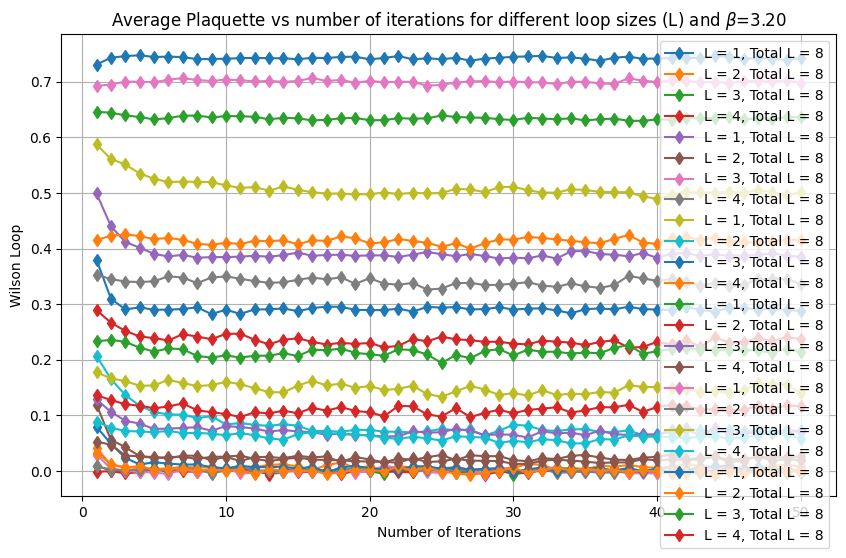

In [ ]:
# Define the varying beta values and lattice sizes (if not already defined)
beta_values = [1.2,1.6,2,2.4,2.8,3.2]     #np.linspace(1.0, 3.0, 10) #
lattice_sizes = [8]         # Lattice sizes to simulate
N = 50                                # Number of Monte Carlo sweeps

iteration_count = len(results[0]['Wilson']) # Assuming all betas have the same number of iterations
iterations = np.arange(1, iteration_count + 1)

# Iterate over lattice sizes
for L in lattice_sizes:
    plt.figure(figsize=(10, 6))
    # Iterate over beta values
    for beta in beta_values:
        # Find the result for the current beta and L
        result_for_beta_L = next((r for r in results if r['Beta'] == beta and r['Lattice_Size'] == L), None)
        if result_for_beta_L:
            wilson_values = result_for_beta_L['Wilson']

            # Get the base color for the current total lattice size (L)

            # Iterate over loop sizes (up to L-1)
            for loop_index in range(len(wilson_values[0]['loop_size'])):
                wilson_values_for_plot = [d['wilson_values'][loop_index] for d in wilson_values]
                loop_size = wilson_values[0]['loop_size'][loop_index]  # Get the loop size

                # Calculate the shade based on loop_index

                # Plot the Wilson loop values against the number of iterations
                plt.plot(iterations, wilson_values_for_plot, marker='d',
                         label=f"L = {loop_size}, Total L = {L}")#,

                # Calculate and plot the mean value of the last 30 points
                #mean_last_30 = np.mean(wilson_values_for_plot[-30:])
                #print(mean_last_30)
                #plt.axhline(y=mean_last_30, color='r', linestyle='--',
                            #label=f"Mean (Last 30) for L = {loop_size}, Total L = {L}")

    plt.title(f"Average Plaquette vs number of iterations for different loop sizes (L) and $\\beta$={beta:.2f}")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Wilson Loop")
    plt.legend()
    plt.grid()
    plt.show()

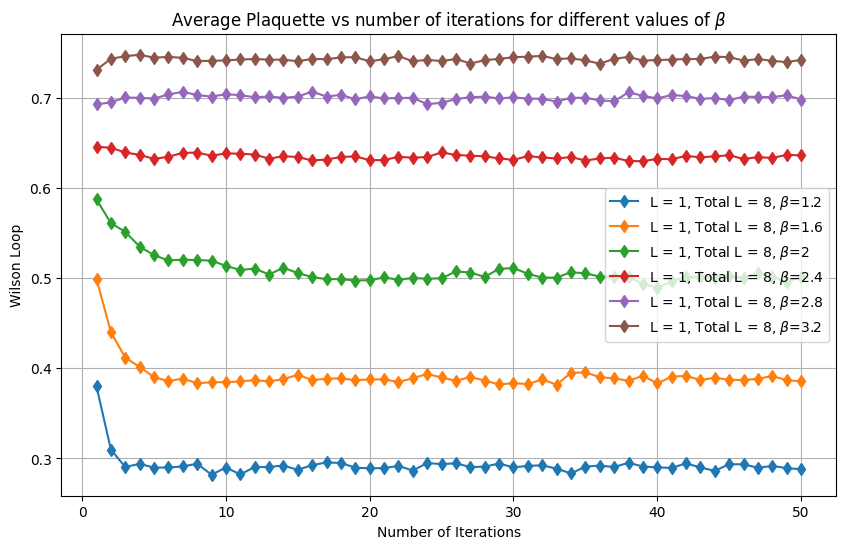

In [ ]:
# Define the varying beta values and lattice sizes (if not already defined)
beta_values = [1.2,1.6,2,2.4,2.8,3.2]     #np.linspace(1.0, 3.0, 10) #
lattice_sizes = [8]         # Lattice sizes to simulate
N = 50                                # Number of Monte Carlo sweeps

iteration_count = len(results[0]['Wilson']) # Assuming all betas have the same number of iterations
iterations = np.arange(1, iteration_count + 1)
# Iterate over lattice sizes
for L in lattice_sizes:
    plt.figure(figsize=(10, 6))
    # Iterate over beta values
    for beta in beta_values:
        # Find the result for the current beta and L
        result_for_beta_L = next((r for r in results if r['Beta'] == beta and r['Lattice_Size'] == L), None)
        if result_for_beta_L:
            wilson_values = result_for_beta_L['Wilson']

            # *** Modification here ***
            # Instead of iterating over all loop sizes, directly access loop_size = 1:
            loop_index = 0  # Index for loop_size = 1 (assuming it's the first in the list)
            wilson_values_for_plot = [d['wilson_values'][loop_index] for d in wilson_values]
            loop_size = wilson_values[0]['loop_size'][loop_index]  # Get the loop size (should be 1)

            # Plot the Wilson loop values against the number of iterations
            plt.plot(iterations, wilson_values_for_plot, marker='d',
                     label=f"L = {loop_size}, Total L = {L}, $\\beta$={beta}")


            # Calculate and plot the mean value of the last 30 points
            #mean_last_30 = np.mean(wilson_values_for_plot[-30:])
            #print(mean_last_30)
            #plt.axhline(y=mean_last_30, color='r', linestyle='--')

    plt.title(f"Average Plaquette vs number of iterations for different values of $\\beta$")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Wilson Loop")
    plt.legend()
    plt.grid()
    plt.show()

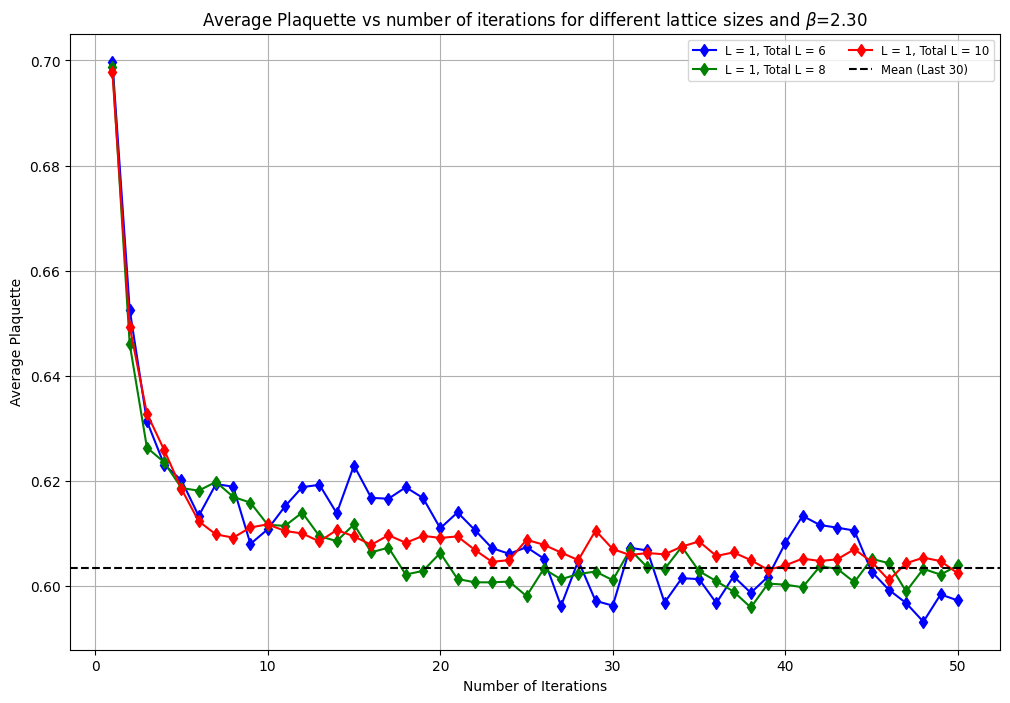

In [ ]:
import matplotlib.cm as cm  # Import colormap module

# Define a color map to assign distinct colors to L=6, 8, and 10
custom_colors = {
    6: 'blue',   # Blue for L=6
    8: 'green',  # Green for L=8
    10: 'red'    # Red for L=10
}

plt.figure(figsize=(12, 8))  # Adjust figure size as needed

# Iterate over beta values
for beta_value in beta_values:
    # Iterate over lattice sizes
    for i, L in enumerate(lattice_sizes):
        # Find the result for the current beta and L
        result_for_beta_L = next((r for r in results if r['Beta'] == beta_value and r['Lattice_Size'] == L), None)

        if result_for_beta_L:
            wilson_values = result_for_beta_L['Wilson']

            # Get the color for the current total lattice size (L)
            color = custom_colors.get(L, 'black')  # Use custom color if defined, otherwise black

            # Iterate over loop sizes (up to L-1)
            for loop_index in range(len(wilson_values[0]['loop_size'])):
                wilson_values_for_plot = [d['wilson_values'][loop_index] for d in wilson_values]
                loop_size = wilson_values[0]['loop_size'][loop_index]  # Get the loop size

                # Plot the Wilson loop values against the number of iterations
                plt.plot(iterations, wilson_values_for_plot, marker='d',
                         label=f"L = {loop_size}, Total L = {L}",
                         color=color)  # Use the fixed color

plt.axhline(y=0.6035, color='black', linestyle='--', label=f"Mean (Last 30)")
plt.title(f"Average Plaquette vs number of iterations for different lattice sizes and $\\beta$={beta_value:.2f}")
plt.xlabel("Number of Iterations")
plt.ylabel("Average Plaquette")
plt.legend(fontsize='small', ncol=2)  # Adjust legend fontsize/columns if needed
plt.grid()
plt.show()

In [ ]:
import matplotlib.cm as cm  # Import colormap module
# Define a color map to assign colors to different total lattice sizes (L)
colors = {2: 'Reds', 3: 'Blues', 4: 'Greens', 5: 'Oranges', 6: 'Purples',
          7: 'YlOr', 8: 'PiYG', 9: 'Greys'}
# Iterate over beta values
for beta_value in beta_values:
    plt.figure(figsize=(10, 6))

    # Iterate over lattice sizes
    for i, L in enumerate(lattice_sizes):
        # Find the result for the current beta and L
        result_for_beta_L = next((r for r in results if r['Beta'] == beta_value and r['Lattice_Size'] == L), None)

        if result_for_beta_L:
            wilson_values = result_for_beta_L['Wilson']

            # Get the base color for the current total lattice size (L)
            base_color = colors.get(L, 'black')

            # Create a colormap for shades of the base color
            cmap = cm.get_cmap(base_color)

            # Iterate over loop sizes (up to L-1)
            for loop_index in range(len(wilson_values[0]['loop_size'])):
                wilson_values_for_plot = [d['wilson_values'][loop_index] for d in wilson_values]
                loop_size = wilson_values[0]['loop_size'][loop_index]  # Get the loop size

                # Calculate the shade based on loop_index
                shade = loop_index / len(wilson_values[0]['loop_size'])

                if loop_size == 1:
                    plt.plot(iterations, wilson_values_for_plot, marker='d',
                             label=f"L = {loop_size}, Total L = {L}",
                             color='black')
                else:
                    plt.plot(iterations, wilson_values_for_plot, marker='d',
                         label=f"L = {loop_size}, Total L = {L}",
                         color=cmap(shade))  # Use the shade from the colormap

    plt.title(f"Wilson Loop vs Number of Iterations for Different Loop Sizes (L) and Beta={beta_value:.2f}")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Wilson Loop")
    plt.legend()
    plt.grid()
    plt.show()
    wall()

## Main: Wilson loop depending on beta

In [ ]:
beta_values = np.linspace(0.1, 4.0, 12)
print(beta_values)

[0.1        0.45454545 0.80909091 1.16363636 1.51818182 1.87272727
 2.22727273 2.58181818 2.93636364 3.29090909 3.64545455 4.        ]


In [ ]:
# Define the varying beta values and lattice sizes
beta_values = [2.58181818, 2.93636364, 3.29090909, 3.64545455, 4] #np.linspace(0.1, 4.0, 12)
lattice_sizes = [10]         # Lattice sizes to simulate
N = 80                                  # Number of Monte Carlo sweeps

# Placeholder to store results
results = []

# Iterate over lattice sizes
for L in lattice_sizes:
    print(f"Starting simulation for lattice size L={L}")
    print('_'*50)
    print('\n')

    # Iterate over beta values
    for beta in beta_values:
        print(f"  Beta: {beta}")

        # Initialize the lattice in the 'Cold'/'Hot' state
        U = initialize_lattice(L, state='Cold')

        # Collectors for Plaquette and Wilson values
        plaquette_collector = []
        wilson_collector = []
        separated_wilson_values={}

        # Perform Monte Carlo sweeps
        for sweep in range(1, N + 1):
            U, wilson = montecarlo_upgrade_lattice(U, L, beta,w_loop='All')

            # Collect the results
            wilson_collector.append(wilson)

            # Optional: Print progress every 10 sweeps
            if sweep % 10 == 0:
                print(f"    Sweep {sweep} completed for Beta={beta}, L={L}")
        print('\n')

        # Store results for this beta and lattice size
        results.append({
            'Lattice_Size': L,
            'Beta': beta,
            'Wilson': wilson_collector
        })
        print(results)


    print('_'*50)
    print(f"Finished simulation for lattice size L={L}")
    wall()

print("Monte Carlo simulation completed.")


Starting simulation for lattice size L=10
__________________________________________________


  Beta: 2.58181818
    Sweep 10 completed for Beta=2.58181818, L=10
    Sweep 20 completed for Beta=2.58181818, L=10
    Sweep 30 completed for Beta=2.58181818, L=10
    Sweep 40 completed for Beta=2.58181818, L=10
    Sweep 50 completed for Beta=2.58181818, L=10
    Sweep 60 completed for Beta=2.58181818, L=10
    Sweep 70 completed for Beta=2.58181818, L=10
    Sweep 80 completed for Beta=2.58181818, L=10


  Beta: 2.93636364
    Sweep 10 completed for Beta=2.93636364, L=10
    Sweep 20 completed for Beta=2.93636364, L=10
    Sweep 30 completed for Beta=2.93636364, L=10
    Sweep 40 completed for Beta=2.93636364, L=10
    Sweep 50 completed for Beta=2.93636364, L=10
    Sweep 60 completed for Beta=2.93636364, L=10
    Sweep 70 completed for Beta=2.93636364, L=10
    Sweep 80 completed for Beta=2.93636364, L=10


  Beta: 3.29090909
    Sweep 10 completed for Beta=3.29090909, L=10
    Sweep 2

In [ ]:
loop_sizes=[1, 2, 3, 4, 5]
beta_values = []
mean_wilson_values = {loop_size: [] for loop_size in loop_sizes}

for result in results:
    L = result['Lattice_Size']
    beta = result['Beta']
    wilson_data = result['Wilson']

    beta_values.append(beta)

    for loop_size in loop_sizes:
        # Extract loop values, skipping the first 20 for thermalization
        loop_values_for_beta_L = [d['wilson_values'][loop_size - 1]
                                  for d in wilson_data[20:]]
        mean_wilson_values[loop_size].append(np.mean(loop_values_for_beta_L))

print(mean_wilson_values)

{1: [0.5342448043963964, 0.5734293023353014], 2: [0.10069167419760575, 0.14339074186478667], 3: [0.00743272771501869, 0.020346375233085013], 4: [-0.0015295833821443506, 0.0005475356119259685], 5: [-0.0009535953656113859, -0.00029019037438027224]}


In [ ]:
##################### SAVE HERE MEAN WILSON VALUES #########################


### Plot wilson depending in beta

{1: [0.5342448043963964, 0.5734293023353014], 2: [0.10069167419760575, 0.14339074186478667], 3: [0.00743272771501869, 0.020346375233085013], 4: [-0.0015295833821443506, 0.0005475356119259685], 5: [-0.0009535953656113859, -0.00029019037438027224]}


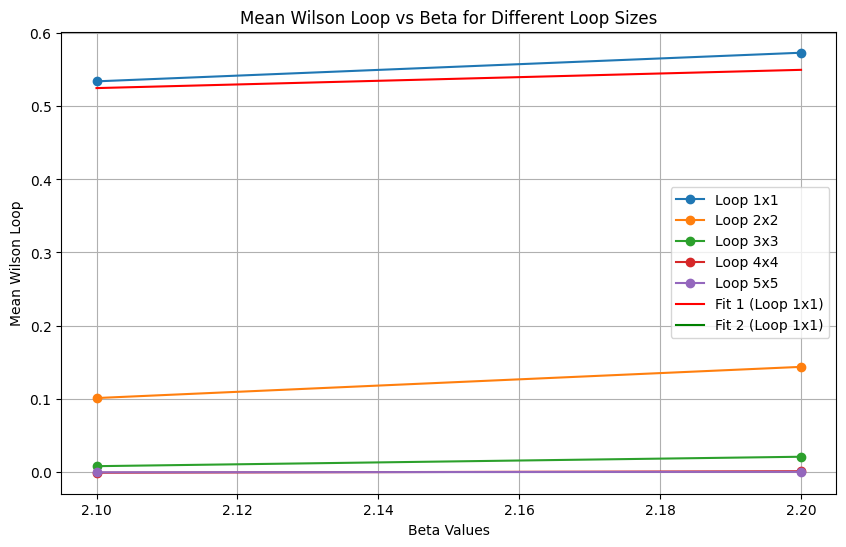

In [ ]:
from scipy.optimize import curve_fit


def plot_wilson_loops(results, loop_sizes=[1, 2, 3, 4,5]):
    """
    Plots the mean Wilson loop values for multiple loop sizes against beta.

    Args:
        results: List of dictionaries containing simulation results.
        loop_sizes: List of loop sizes to plot. Defaults to [1, 2, 3, 4, 5].
    """

    beta_values = []  # Initialize as a list
    mean_wilson_values = {loop_size: [] for loop_size in loop_sizes}

    for result in results:
        L = result['Lattice_Size']
        beta = result['Beta']
        wilson_data = result['Wilson']

        beta_values.append(beta)

        for loop_size in loop_sizes:
            # Extract loop values, skipping the first 20 for thermalization
            loop_values_for_beta_L = [d['wilson_values'][loop_size - 1]
                                     for d in wilson_data[20:]]
            mean_wilson_values[loop_size].append(np.mean(loop_values_for_beta_L))

    print(mean_wilson_values)

    # Plotting
    plt.figure(figsize=(10, 6))
    for loop_size in loop_sizes:
        plt.plot(beta_values, mean_wilson_values[loop_size], marker='o',
                 linestyle='-', label=f'Loop {loop_size}x{loop_size}')


    def func1(x):
      return x / 4  # beta/4

    def func2(x):
      return 1 - 3 / (4 * x)  # 1-3/(4*beta)

    # Fit to func1
    plt.plot(beta_values[:15], func1(np.array(beta_values[:15])), 'r-',
              label=f'Fit 1 (Loop {1}x{1})')  # Red line

    # Add equation for func1 to the plot
    #equation1 = f'y = (1/4)x'
    #plt.text(beta_values[5]+0.2, func1(beta_values[5]), equation1, color='r')

    # Fit to func2
    plt.plot(beta_values[15:], func2(np.array(beta_values[15:])), 'g-',
              label=f'Fit 2 (Loop {1}x{1})')  # Green line

    # Add equation for func2 to the plot
    #equation2 = f'y = 1 - 3/(4x)'
    #plt.text(beta_values[20]+0.2, func2(beta_values[20])-0.05, equation2, color='g')


    plt.title('Mean Wilson Loop vs Beta for Different Loop Sizes')
    plt.xlabel('Beta Values')
    plt.ylabel('Mean Wilson Loop')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot
plot_wilson_loops(results)

In [ ]:
from scipy.optimize import curve_fit


def plot_wilson_loops(results, loop_sizes=[1, 2, 3, 4,5]):
    """
    Plots the mean Wilson loop values for multiple loop sizes against beta.

    Args:
        results: List of dictionaries containing simulation results.
        loop_sizes: List of loop sizes to plot. Defaults to [1, 2, 3, 4, 5].
    """

    #beta_values = np.linspace(0.1, 4.0, 25)
    beta_values_list = []  # Initialize as a list
    mean_wilson_values = {loop_size: [] for loop_size in loop_sizes}

    for result in results:
        L = result['Lattice_Size']
        beta = result['Beta']
        wilson_data = result['Wilson']

        beta_values.append(beta)

        for loop_size in loop_sizes:
            # Extract loop values, skipping the first 20 for thermalization
            loop_values_for_beta_L = [d['wilson_values'][loop_size - 1]
                                     for d in wilson_data[20:]]
            mean_wilson_values[loop_size].append(np.mean(loop_values_for_beta_L))

    print(mean_wilson_values)

    # Plotting
    plt.figure(figsize=(10, 6))
    for loop_size in loop_sizes:
        plt.plot(beta_values, mean_wilson_values[loop_size], marker='o',
                 linestyle='-', label=f'Loop {loop_size}x{loop_size}')


    def func1(x):
      return x / 4  # beta/4

    def func2(x):
      return 1 - 3 / (4 * x)  # 1-3/(4*beta)

    # Fit to func1
    plt.plot(beta_values[:15], func1(np.array(beta_values[:15])), 'r-',
              label=f'Fit 1 (Loop {1}x{1})')  # Red line

    # Add equation for func1 to the plot
    equation1 = f'y = (1/4)x'
    plt.text(beta_values[5]+0.2, func1(beta_values[5]), equation1, color='r')

    # Fit to func2
    plt.plot(beta_values[15:], func2(np.array(beta_values[15:])), 'g-',
              label=f'Fit 2 (Loop {1}x{1})')  # Green line

    # Add equation for func2 to the plot
    equation2 = f'y = 1 - 3/(4x)'
    plt.text(beta_values[20]+0.2, func2(beta_values[20])-0.05, equation2, color='g')


    plt.title('Mean Wilson Loop vs Beta for Different Loop Sizes')
    plt.xlabel('Beta Values')
    plt.ylabel('Mean Wilson Loop')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming 'results' is your list of dictionaries from the simulation
# Call the function to plot
plot_wilson_loops(results)

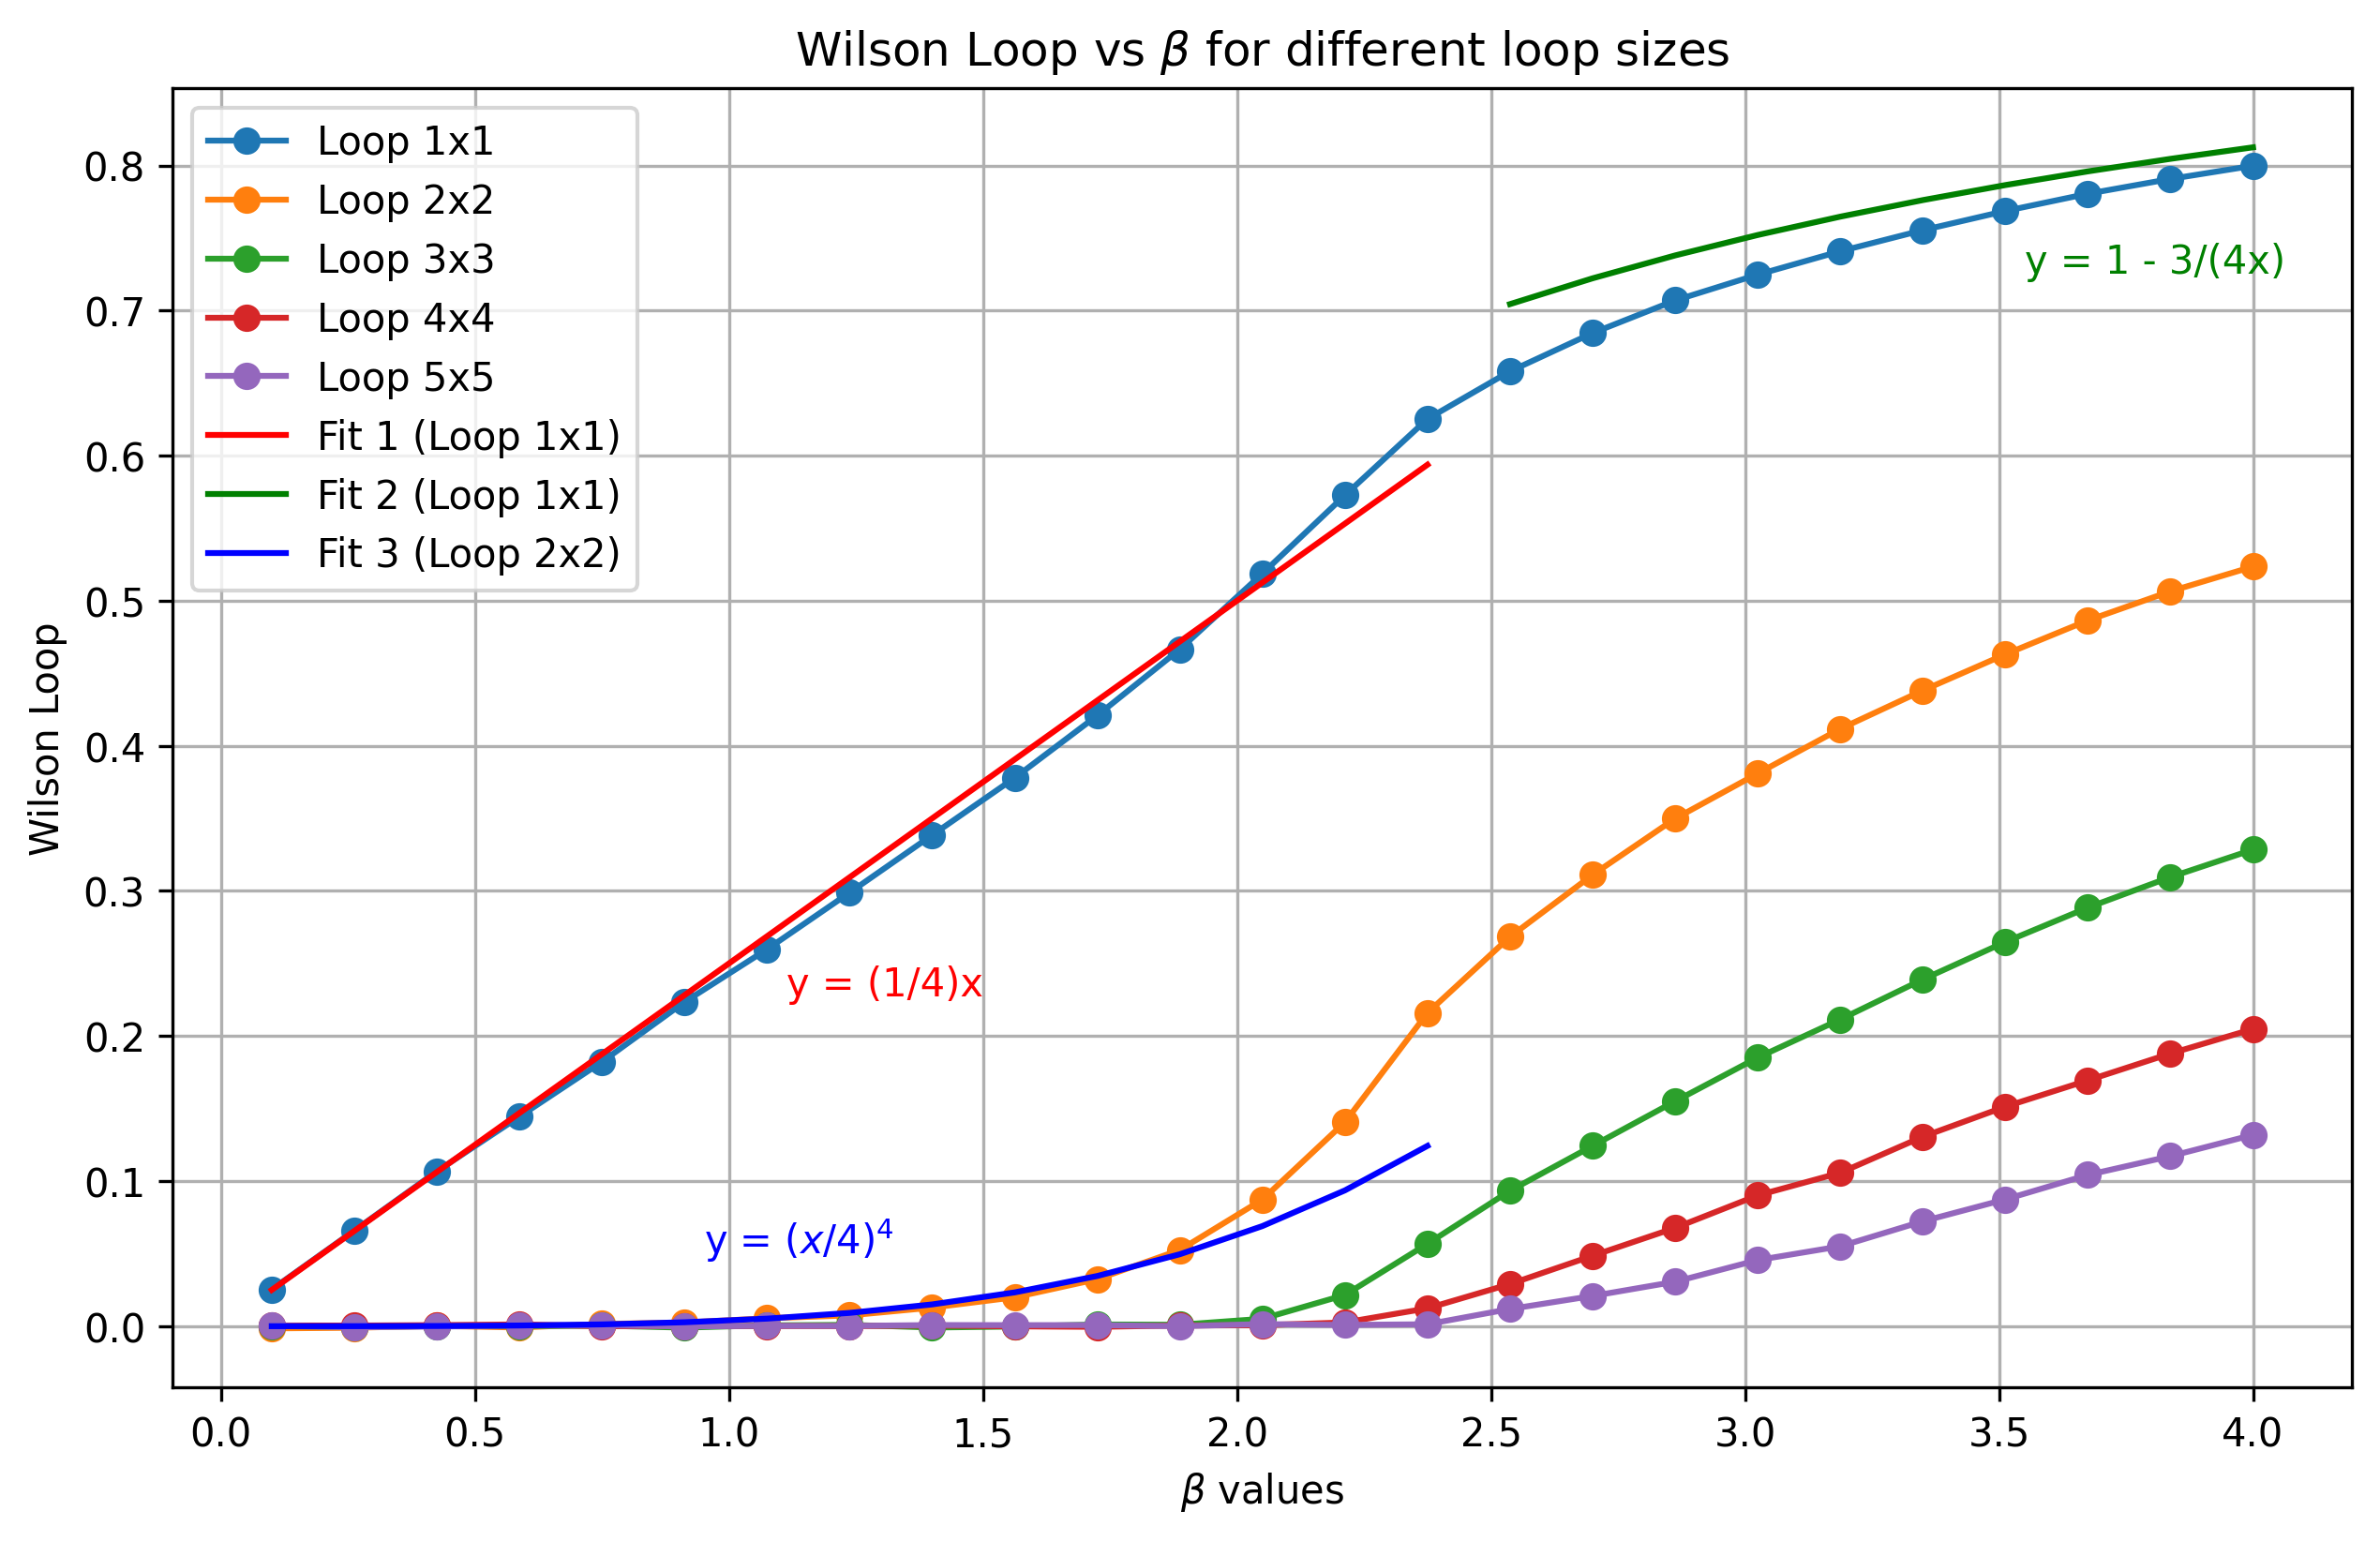

In [ ]:
from scipy.optimize import curve_fit


def plot_wilson_loops(results, loop_sizes=[1, 2, 3, 4, 5]):
    """
    Plots the mean Wilson loop values for multiple loop sizes against beta.

    Args:
        results: List of dictionaries containing simulation results.
        loop_sizes: List of loop sizes to plot. Defaults to [1, 2, 3, 4, 5].
    """

    beta_values = np.linspace(0.1, 4.0, 25)

    '''
    for result in results:
        L = result['Lattice_Size']
        beta = result['Beta']
        wilson_data = result['Wilson']

        beta_values.append(beta)

        for loop_size in loop_sizes:
            # Extract loop values, skipping the first 20 for thermalization
            loop_values_for_beta_L = [d['wilson_values'][loop_size - 1]
                                     for d in wilson_data[20:]]
            mean_wilson_values[loop_size].append(np.mean(loop_values_for_beta_L))
    '''

    # L=8, from 0.1 to 4, 25 points, 40 times - 20 thermalization
    mean_wilson_values={1: [0.025325392772154582, 0.06588538604501096, 0.1067231666169877, 0.1444435537109859, 0.18218054961642138, 0.22342968975948385, 0.2597691987689263, 0.29883704024046753, 0.3384433956133165, 0.37793551936721087, 0.4208829289699584, 0.46652237048217177, 0.5186980800054803, 0.5726932155121806, 0.6253080783877343, 0.6581299421630231, 0.684498857651287, 0.7069876619747312, 0.7247578556641205, 0.7408733366091089, 0.7553971073892864, 0.7686115323264954, 0.7805169996398655, 0.7907067499997028, 0.7997924413852366],
                        2: [-0.0015091757593887164, -0.0010878504393149104, 0.00021503135341893569, -0.0009160233420421769, 0.0015530617730870279, 0.0025122769080977787, 0.005453719263838225, 0.007456461370503657, 0.012804182106562262, 0.01990470600712647, 0.03237261065584768, 0.05250988515171094, 0.0872485214563542, 0.14063545592685583, 0.2159237154622975, 0.2683997355303872, 0.3110734982972692, 0.3498383338293326, 0.38093114636883163, 0.4116959362532878, 0.4381533972142808, 0.46308588077034846, 0.48644466112842827, 0.506496911596878, 0.5235356800995643],
                        3: [8.242191364646079e-05, -0.0004571447149867294, 3.55290018814356e-05, 4.8755262348371193e-05, 0.00034369165373177935, -0.0009908682125781762, 0.0005822185767757565, 0.0009108925340830087, -0.0009167935726170125, -0.0002469903389006665, 0.0011752843117499951, 0.0010033304396733713, 0.005104056185445177, 0.02150625204274937, 0.05676932673289283, 0.09334420167973886, 0.12426753445831759, 0.15503890040067186, 0.18511551158600525, 0.21142395333304714, 0.23899737454289624, 0.26484386132871, 0.2885230470755832, 0.3095427091510074, 0.32846422269739955],
                        4: [0.0004980767656675401, 0.0004365027269782576, 0.0007287103269675634, 0.0012251381593672956, -3.48586146557302e-06, -5.488782743848287e-05, 0.00012974043423909047, 6.883982029980125e-05, 0.00043080120848148834, -0.00012005463665996064, -0.0004608476674161473, 0.00047391941367469736, 0.000714064065973722, 0.0025928084467633536, 0.012313668415431318, 0.02904575512136075, 0.048544843716548616, 0.06775168549937666, 0.09016686449840981, 0.1057325259791692, 0.13061120815162006, 0.15131427441031783, 0.16944789803833968, 0.1879218443009178, 0.20484868818756716],
                        5: [0.00035111299705438333, -0.0007797594837026107, -0.00023960177941616934, 0.00039447502665439053, 0.0005934340070051525, -0.0001756975446253049, 0.0002354433084785861, 0.00018506728046362237, 0.0007953576624440848, 0.0007255367169702023, 0.0007468729545425109, -6.473157932599793e-06, 0.001454647307976983, 0.0008828207624891448, 0.0013492487943892989, 0.01184997655677379, 0.020840245096791075, 0.030632489269796864, 0.04557691207750171, 0.05503784215944594, 0.07230103744090828, 0.08739999645989249, 0.10427850309178673, 0.11716177913228457, 0.13186037814112012]
                        }
    #print(mean_wilson_values)

    # Plotting
    plt.figure(figsize=(10, 6), dpi = 300)
    for loop_size in loop_sizes:
        plt.plot(beta_values, mean_wilson_values[loop_size], marker='o',
                 linestyle='-', label=f'Loop {loop_size}x{loop_size}')


    def func1(x):
      return x / 4  # beta/4

    def func2(x):
      return 1 - 3 / (4 * x)  # 1-3/(4*beta)

    def func3(x):
      return (x/4)**4  # (beta/4)**4



    # Fit to func1
    plt.plot(beta_values[:15], func1(np.array(beta_values[:15])), 'r-',
              label=f'Fit 1 (Loop {1}x{1})')  # Red line

    # Add equation for func1 to the plot
    equation1 = f'y = (1/4)x'
    plt.text(beta_values[5]+0.2, func1(beta_values[5]), equation1, color='r')

    # Fit to func2
    plt.plot(beta_values[15:], func2(np.array(beta_values[15:])), 'g-',
              label=f'Fit 2 (Loop {1}x{1})')  # Green line

    # Add equation for func2 to the plot
    equation2 = f'y = 1 - 3/(4x)'
    plt.text(beta_values[20]+0.2, func2(beta_values[20])-0.05, equation2, color='g')

    # Fit to func3
    plt.plot(beta_values[:15], func3(np.array(beta_values[:15])), 'b-',
              label=f'Fit 3 (Loop {2}x{2})')  # BLue line

    # Add equation for func2 to the plot
    equation2 = f'y = $(x/4)^4$ '
    plt.text(beta_values[4]+0.2, func2(beta_values[4])+0.05, equation2, color='b')


    plt.title('Wilson Loop vs $\\beta$ for different loop sizes')
    plt.xlabel('$\\beta$ values')
    plt.ylabel('Wilson Loop')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming 'results' is your list of dictionaries from the simulation
# Call the function to plot
plot_wilson_loops(results)

In [ ]:
# L=8, from 0.1 to 4, 25 points, 40 times - 20 thermalization
mean_wilson_values={1: [0.025325392772154582, 0.06588538604501096, 0.1067231666169877, 0.1444435537109859, 0.18218054961642138, 0.22342968975948385, 0.2597691987689263, 0.29883704024046753, 0.3384433956133165, 0.37793551936721087, 0.4208829289699584, 0.46652237048217177, 0.5186980800054803, 0.5726932155121806, 0.6253080783877343, 0.6581299421630231, 0.684498857651287, 0.7069876619747312, 0.7247578556641205, 0.7408733366091089, 0.7553971073892864, 0.7686115323264954, 0.7805169996398655, 0.7907067499997028, 0.7997924413852366], 2: [-0.0015091757593887164, -0.0010878504393149104, 0.00021503135341893569, -0.0009160233420421769, 0.0015530617730870279, 0.0025122769080977787, 0.005453719263838225, 0.007456461370503657, 0.012804182106562262, 0.01990470600712647, 0.03237261065584768, 0.05250988515171094, 0.0872485214563542, 0.14063545592685583, 0.2159237154622975, 0.2683997355303872, 0.3110734982972692, 0.3498383338293326, 0.38093114636883163, 0.4116959362532878, 0.4381533972142808, 0.46308588077034846, 0.48644466112842827, 0.506496911596878, 0.5235356800995643], 3: [8.242191364646079e-05, -0.0004571447149867294, 3.55290018814356e-05, 4.8755262348371193e-05, 0.00034369165373177935, -0.0009908682125781762, 0.0005822185767757565, 0.0009108925340830087, -0.0009167935726170125, -0.0002469903389006665, 0.0011752843117499951, 0.0010033304396733713, 0.005104056185445177, 0.02150625204274937, 0.05676932673289283, 0.09334420167973886, 0.12426753445831759, 0.15503890040067186, 0.18511551158600525, 0.21142395333304714, 0.23899737454289624, 0.26484386132871, 0.2885230470755832, 0.3095427091510074, 0.32846422269739955], 4: [0.0004980767656675401, 0.0004365027269782576, 0.0007287103269675634, 0.0012251381593672956, -3.48586146557302e-06, -5.488782743848287e-05, 0.00012974043423909047, 6.883982029980125e-05, 0.00043080120848148834, -0.00012005463665996064, -0.0004608476674161473, 0.00047391941367469736, 0.000714064065973722, 0.0025928084467633536, 0.012313668415431318, 0.02904575512136075, 0.048544843716548616, 0.06775168549937666, 0.09016686449840981, 0.1057325259791692, 0.13061120815162006, 0.15131427441031783, 0.16944789803833968, 0.1879218443009178, 0.20484868818756716], 5: [0.00035111299705438333, -0.0007797594837026107, -0.00023960177941616934, 0.00039447502665439053, 0.0005934340070051525, -0.0001756975446253049, 0.0002354433084785861, 0.00018506728046362237, 0.0007953576624440848, 0.0007255367169702023, 0.0007468729545425109, -6.473157932599793e-06, 0.001454647307976983, 0.0008828207624891448, 0.0013492487943892989, 0.01184997655677379, 0.020840245096791075, 0.030632489269796864, 0.04557691207750171, 0.05503784215944594, 0.07230103744090828, 0.08739999645989249, 0.10427850309178673, 0.11716177913228457, 0.13186037814112012]}

In [ ]:
loop_1=[0.025325392772154582, 0.06588538604501096, 0.1067231666169877, 0.1444435537109859, 0.18218054961642138, 0.22342968975948385, 0.2597691987689263, 0.29883704024046753, 0.3384433956133165, 0.37793551936721087, 0.4208829289699584, 0.46652237048217177, 0.5186980800054803, 0.5726932155121806, 0.6253080783877343, 0.6581299421630231, 0.684498857651287, 0.7069876619747312, 0.7247578556641205, 0.7408733366091089, 0.7553971073892864, 0.7686115323264954, 0.7805169996398655, 0.7907067499997028, 0.7997924413852366]
loop_2=[-0.0015091757593887164, -0.0010878504393149104, 0.00021503135341893569, -0.0009160233420421769, 0.0015530617730870279, 0.0025122769080977787, 0.005453719263838225, 0.007456461370503657, 0.012804182106562262, 0.01990470600712647, 0.03237261065584768, 0.05250988515171094, 0.0872485214563542, 0.14063545592685583, 0.2159237154622975, 0.2683997355303872, 0.3110734982972692, 0.3498383338293326, 0.38093114636883163, 0.4116959362532878, 0.4381533972142808, 0.46308588077034846, 0.48644466112842827, 0.506496911596878, 0.5235356800995643]
loop_3=[8.242191364646079e-05, -0.0004571447149867294, 3.55290018814356e-05, 4.8755262348371193e-05, 0.00034369165373177935, -0.0009908682125781762, 0.0005822185767757565, 0.0009108925340830087, -0.0009167935726170125, -0.0002469903389006665, 0.0011752843117499951, 0.0010033304396733713, 0.005104056185445177, 0.02150625204274937, 0.05676932673289283, 0.09334420167973886, 0.12426753445831759, 0.15503890040067186, 0.18511551158600525, 0.21142395333304714, 0.23899737454289624, 0.26484386132871, 0.2885230470755832, 0.3095427091510074, 0.32846422269739955]
loop_4=[0.0004980767656675401, 0.0004365027269782576, 0.0007287103269675634, 0.0012251381593672956, -3.48586146557302e-06, -5.488782743848287e-05, 0.00012974043423909047, 6.883982029980125e-05, 0.00043080120848148834, -0.00012005463665996064, -0.0004608476674161473, 0.00047391941367469736, 0.000714064065973722, 0.0025928084467633536, 0.012313668415431318, 0.02904575512136075, 0.048544843716548616, 0.06775168549937666, 0.09016686449840981, 0.1057325259791692, 0.13061120815162006, 0.15131427441031783, 0.16944789803833968, 0.1879218443009178, 0.20484868818756716]
loop_5=[0.00035111299705438333, -0.0007797594837026107, -0.00023960177941616934, 0.00039447502665439053, 0.0005934340070051525, -0.0001756975446253049, 0.0002354433084785861, 0.00018506728046362237, 0.0007953576624440848, 0.0007255367169702023, 0.0007468729545425109, -6.473157932599793e-06, 0.001454647307976983, 0.0008828207624891448, 0.0013492487943892989, 0.01184997655677379, 0.020840245096791075, 0.030632489269796864, 0.04557691207750171, 0.05503784215944594, 0.07230103744090828, 0.08739999645989249, 0.10427850309178673, 0.11716177913228457, 0.13186037814112012]

string=[]
beta_values = np.linspace(0.1, 4.0, 25)

for i in range len(loop_1):

  string={beta_values[i]:[loop_1[i],loop_2[i],loop_3[i],loop_4[i],loop_5[i]]}

print(string)


## Main: string tension

In [ ]:
# Define the varying beta values and lattice sizes
beta_values = [1.9,2.1,2.3,2.5] #np.linspace(0.1, 4.0, 25) #[1.2,1.6,2,2.4,2.8,3.2]
lattice_sizes = [10]         # Lattice sizes to simulate
N = 80                              # Number of Monte Carlo sweeps

# Placeholder to store results
results = []
U={}
# Iterate over lattice sizes
for L in lattice_sizes:
    print(f"Starting simulation for lattice size L={L}")
    print('_'*50)
    print('\n')

    # Iterate over beta values
    for beta in beta_values:
        print(f"  Beta: {beta}")
        wall()

        # Initialize the lattice in the 'Cold'/'Hot' state
        U = initialize_lattice(L, state='Cold')

        # Collectors for Plaquette and Wilson values
        wilson_collector = []

        # Perform Monte Carlo sweeps
        for sweep in range(1, N + 1):
            U, wilson = montecarlo_upgrade_lattice(U, L, beta,w_loop='All')

            # Collect the results
            wilson_collector.append(wilson)

            # Optional: Print progress every 10 sweeps
            if sweep % 10 == 0:
                print(f"    Sweep {sweep} completed for Beta={beta}, L={L}")
        print('\n')

        # Store results for this beta and lattice size
        results.append({
            'Lattice_Size': L,
            'Beta': beta,
            'Wilson': wilson_collector,
        })

    print('_'*50)
    print(f"Finished simulation for lattice size L={L}")
    wall()

print("Monte Carlo simulation completed.")


Starting simulation for lattice size L=10
__________________________________________________


  Beta: 1.9


####################################################################################################


    Sweep 10 completed for Beta=1.9, L=10
    Sweep 20 completed for Beta=1.9, L=10
    Sweep 30 completed for Beta=1.9, L=10
    Sweep 40 completed for Beta=1.9, L=10
    Sweep 50 completed for Beta=1.9, L=10
    Sweep 60 completed for Beta=1.9, L=10
    Sweep 70 completed for Beta=1.9, L=10
    Sweep 80 completed for Beta=1.9, L=10


  Beta: 2.1


####################################################################################################


    Sweep 10 completed for Beta=2.1, L=10
    Sweep 20 completed for Beta=2.1, L=10
    Sweep 30 completed for Beta=2.1, L=10
    Sweep 40 completed for Beta=2.1, L=10
    Sweep 50 completed for Beta=2.1, L=10
    Sweep 60 completed for Beta=2.1, L=10
    Sweep 70 completed for Beta=2.1, L=10
    Sweep 80 completed for Beta=2.1, L=

In [ ]:
loop_sizes=[1, 2, 3, 4, 5]
beta_values = []
mean_wilson_values = {loop_size: [] for loop_size in loop_sizes}

for result in results:
    L = result['Lattice_Size']
    beta = result['Beta']
    wilson_data = result['Wilson']

    beta_values.append(beta)

    for loop_size in loop_sizes:
        # Extract loop values, skipping the first 20 for thermalization
        loop_values_for_beta_L = [d['wilson_values'][loop_size - 1]
                                  for d in wilson_data[20:]]
        mean_wilson_values[loop_size].append(np.mean(loop_values_for_beta_L))

print(mean_wilson_values)

{1: [0.47023397580826143, 0.534829540322439, 0.603878177459763, 0.6530799625662322], 2: [0.05436000720801829, 0.1000530744356182, 0.18428430544720414, 0.26070735678128937], 3: [0.00200519415482503, 0.00808272172516431, 0.03802190100177039, 0.08586149524404728], 4: [0.00019759639575711552, 0.0007034344926506779, 0.006384404274746845, 0.025775091284103803], 5: [0.0005148496011969213, 0.0003700933412225643, 0.0008971670844759337, 0.007692815824573829]}


In [ ]:
mean_wilson_values={1: [0.47023397580826143, 0.534829540322439, 0.603878177459763, 0.6530799625662322],
 2: [0.05436000720801829, 0.1000530744356182, 0.18428430544720414, 0.26070735678128937],
 3: [0.00200519415482503, 0.00808272172516431, 0.03802190100177039, 0.08586149524404728],
 4: [0.00019759639575711552, 0.0007034344926506779, 0.006384404274746845, 0.025775091284103803],
 5: [0.0005148496011969213, 0.0003700933412225643, 0.0008971670844759337, 0.007692815824573829]
 }


### Plot: fit wilson-loop size

<ipython-input-7-424ca700ea2d>:36: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(wilson_loop_formula, loop_sizes_fit, wilson_values_for_beta)
<ipython-input-7-424ca700ea2d>:6: RuntimeWarning: overflow encountered in exp
  return np.exp(-(A + B * S + C * S**2))


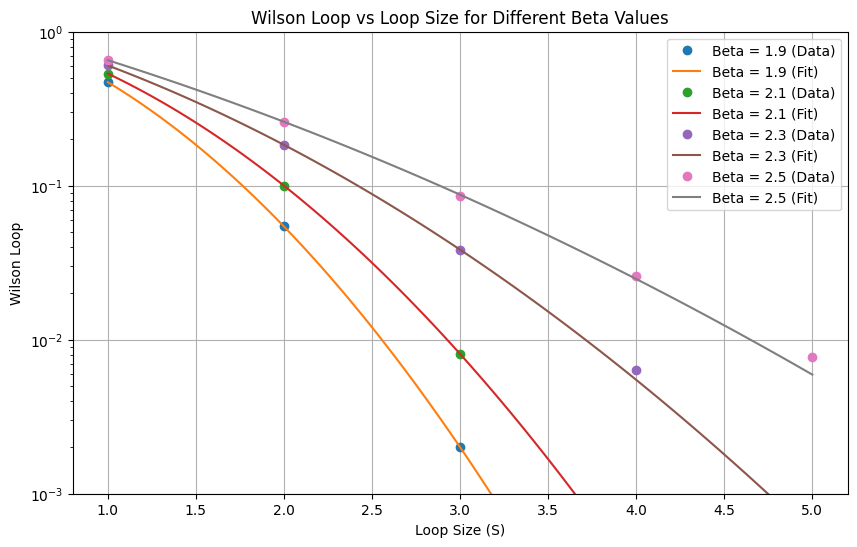

C values for each beta: [0.5711430803329958, 0.4198624181023692, 0.18980255348830155, 0.08484410757403794]


In [ ]:
from scipy.optimize import curve_fit

# Function to compute Wilson loop values based on the given formula
def wilson_loop_formula(S, A, B, C):
    S = np.array(S)
    return np.exp(-(A + B * S + C * S**2))

# Loop side values (S)
loop_sizes = [1, 2, 3, 4, 5]

beta_values = [1.9, 2.1, 2.3, 2.5]

mean_wilson_values={1: [0.47023397580826143, 0.534829540322439, 0.603878177459763, 0.6530799625662322],
 2: [0.05436000720801829, 0.1000530744356182, 0.18428430544720414, 0.26070735678128937],
 3: [0.00200519415482503, 0.00808272172516431, 0.03802190100177039, 0.08586149524404728],
 4: [0.00019759639575711552, 0.0007034344926506779, 0.006384404274746845, 0.025775091284103803],
 5: [0.0005148496011969213, 0.0003700933412225643, 0.0008971670844759337, 0.007692815824573829]
 }

# Perform fitting and plotting for each beta
C_values = []  # Store C values for each beta

plt.figure(figsize=(10, 6))

for beta_index, beta in enumerate(beta_values):
    # Extract Wilson loop values for the current beta
    wilson_values_for_beta = [mean_wilson_values[loop_size][beta_index]
                              for loop_size in loop_sizes]
    if beta == 1.9 or beta == 2.1:
        wilson_values_for_beta = wilson_values_for_beta[:3]
        loop_sizes_fit = loop_sizes[:3]  # Use only the first 3 loop sizes for fit
    else:
        loop_sizes_fit = loop_sizes  # Use all loop sizes for fit

    # Fit the data to the formula
    popt, pcov = curve_fit(wilson_loop_formula, loop_sizes_fit, wilson_values_for_beta)

    # Extract the C value and store it
    A, B, C = popt
    C_values.append(C)

    # Create a continuous range of loop sizes for plotting the fit
    S_continuous = np.linspace(1, 5, 100)  # Values from 0 to 5

    # Plot the original data points
    plt.plot(loop_sizes_fit, wilson_values_for_beta, 'o', label=f'Beta = {beta} (Data)')

    # Plot the fitted curve using the continuous range
    plt.plot(S_continuous, wilson_loop_formula(S_continuous, *popt), '-',
             label=f'Beta = {beta} (Fit)')

plt.ylim(10**(-3),1)
plt.title('Wilson Loop vs loop size for different $\\beta$ values')
plt.xlabel('Loop Size (S)')
plt.ylabel('Wilson Loop')
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

# Print the C values for each beta
print("C values for each beta:", C_values)

In [ ]:
from scipy.optimize import curve_fit

# Function to compute Wilson loop values based on the given formula
def wilson_loop_formula(S, A, B, C):
    S=np.array(S)
    return np.exp(-(A + B * S + C * S**2))

# Loop side values (S)
loop_sizes = [1, 2, 3, 4, 5]

beta_values = [1.9,2.1,2.3,2.5]

# Extract mean Wilson loop values for each loop size

for result in results:  # Assuming 'results' is from your simulation
    beta = result['Beta']
    wilson_data = result['Wilson']
    beta_values.append(beta)

    for loop_size in loop_sizes:
        loop_values_for_beta_L = [d['wilson_values'][loop_size - 1]
                                  for d in wilson_data[20:]]  # Thermalization
        mean_wilson_values[loop_size].append(np.mean(loop_values_for_beta_L))

# Perform fitting and plotting for each beta
C_values = []  # Store C values for each beta



plt.figure(figsize=(10, 6))

for beta_index, beta in enumerate(beta_values):
    # Extract Wilson loop values for the current beta
    wilson_values_for_beta = [mean_wilson_values[loop_size][beta_index]
                              for loop_size in loop_sizes]
    if beta ==1.9 or beta ==2.1:
      wilson_values_for_beta = wilson_values_for_beta[:3]
      loop_sizes = loop_sizes[:3]
      print(wilson_values_for_beta)

    # Fit the data to the formula
    popt, _ = curve_fit(wilson_loop_formula, loop_sizes, wilson_values_for_beta)
    A_fit, B_fit, C_fit = popt
    C_values.append(C_fit)

    # Plot the original data and the fitted curve
    plt.plot(loop_sizes, wilson_values_for_beta, marker='o', linestyle='-',
             label=f'Beta = {beta:.2f} (Data)')
    plt.plot(loop_sizes, wilson_loop_formula(loop_sizes, A_fit, B_fit, C_fit),
             linestyle='--', label=f'Beta = {beta:.2f} (Fit)')
    loop_sizes = [1, 2, 3, 4, 5]


# Set logarithmic y-axis
plt.yscale("log")

# Add labels, title, legend, and grid
plt.xlabel("Loop Side (S)", fontsize=12)
plt.ylabel("Wilson Loop", fontsize=12)
plt.title("Wilson Loop Decay with Loop Side", fontsize=14)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Print C values
print("C values for each beta:", C_values)

NameError: name 'results' is not defined

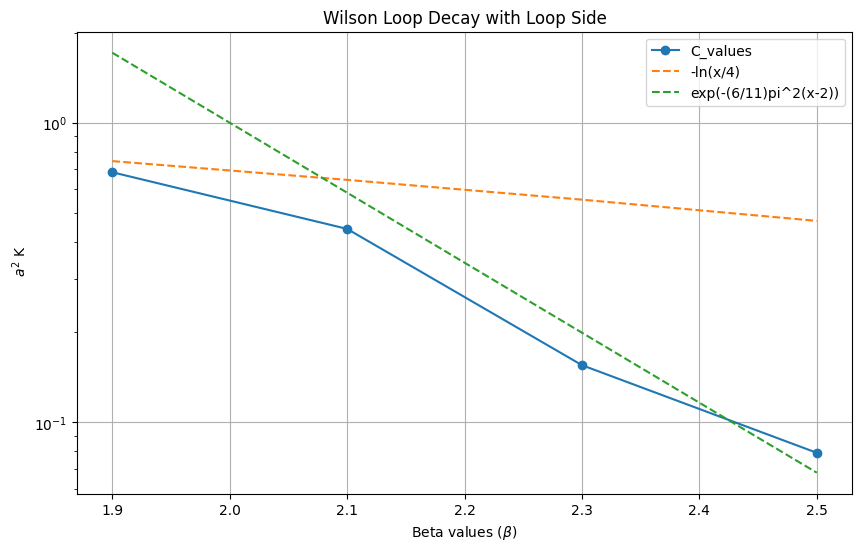

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(beta_values, C_values, marker='o', linestyle='-', label='C_values')
plt.plot(beta_values, func1(np.array(beta_values)), linestyle='--', label='-ln(x/4)')
plt.plot(beta_values, func2(np.array(beta_values)), linestyle='--', label='exp(-(6/11)pi^2(x-2))')


# Set logarithmic y-axis
plt.yscale("log")

# Add labels, title, legend, and grid
plt.xlabel("Beta values ($ \\beta$)")
plt.ylabel(" $a^2$ K" )
plt.title("Wilson Loop Decay with Loop Side")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Plot: string tension diagram

In [ ]:
mean_wilson_values={1: [np.float64(0.02505038322999694), np.float64(0.11262211390804969), np.float64(0.1975741184299703), np.float64(0.28135718262745474), np.float64(0.3674828486336318), np.float64(0.46445724365962016), np.float64(0.579828635147326), np.float64(0.6671996044059337), np.float64(0.7156273203910672), np.float64(0.7511975250811127), np.float64(0.7780807962296347), np.float64(0.799920478544396)],
 2: [np.float64(-0.00017239652355881412), np.float64(2.79682294975685e-05), np.float64(0.001427942243363125), np.float64(0.0065321548141053926), np.float64(0.01937838678526156), np.float64(0.051708436007122716), np.float64(0.15051111381212517), np.float64(0.28313806117467016), np.float64(0.36411794368191297), np.float64(0.43087181292984267), np.float64(0.4811440220128628), np.float64(0.5248201284959995)],
 3: [np.float64(-0.0002871505313155636), np.float64(-0.0004020937423877181), np.float64(-0.00031716088688724174), np.float64(-0.00022474253154372892), np.float64(0.0003794515224092215), np.float64(0.0014087243712006352), np.float64(0.023138715663407413), np.float64(0.10332271212200149), np.float64(0.16813007299554264), np.float64(0.23170676895698727), np.float64(0.2818624977630307), np.float64(0.32955935847235646)],
 4: [np.float64(-0.00014438105016757868), np.float64(-0.00014977773180765167), np.float64(-0.0002727326061813846), np.float64(0.0005813101817324332), np.float64(0.00010592015071482462), np.float64(0.0007196495314322137), np.float64(0.002018057075343225), np.float64(0.03647393679279434), np.float64(0.07522933791748256), np.float64(0.12395409783118039), np.float64(0.16286218602635916), np.float64(0.20569552402531616)],
 5: [np.float64(0.0002667283535897045), np.float64(0.0003785071398638729), np.float64(-0.0007040585151248961), np.float64(2.5027977650511334e-05), np.float64(0.0003896848462246379), np.float64(-0.0002327307051034319), np.float64(0.0004419064249387922), np.float64(0.013495665844533631), np.float64(0.034810184654319995), np.float64(0.06847333716845025), np.float64(0.09619280623167774), np.float64(0.1310614488006787)]
 }

<ipython-input-14-bfc4fd60394b>:40: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(wilson_loop_formula_C, loop_sizes, wilson_values_for_beta)
<ipython-input-14-bfc4fd60394b>:10: RuntimeWarning: overflow encountered in exp
  return np.exp(-(A+B*S+C * S**2))


<Figure size 1000x600 with 0 Axes>

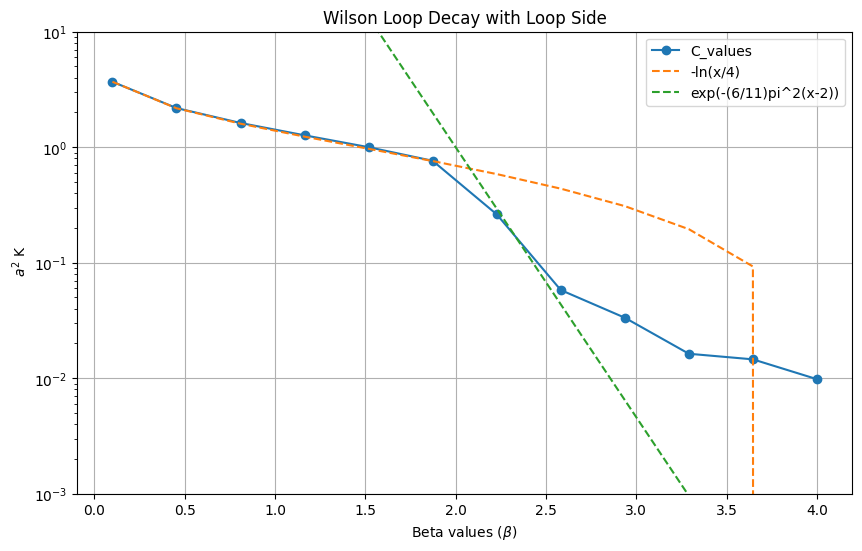

In [ ]:
from scipy.optimize import curve_fit

# Function to compute Wilson loop values based on the given formula
def wilson_loop_formula_C(S, A, B, C):
    S=np.array(S)
    return np.exp(-(+C*S**2))

def wilson_loop_formula_All(S, A, B, C):
    S=np.array(S)
    return np.exp(-(A+B*S+C * S**2))

'''
mean_wilson_values={1: [0.025325392772154582, 0.06588538604501096, 0.1067231666169877, 0.1444435537109859, 0.18218054961642138, 0.22342968975948385, 0.2597691987689263, 0.29883704024046753, 0.3384433956133165, 0.37793551936721087, 0.4208829289699584, 0.46652237048217177, 0.5186980800054803, 0.5726932155121806, 0.6253080783877343, 0.6581299421630231, 0.684498857651287, 0.7069876619747312, 0.7247578556641205, 0.7408733366091089, 0.7553971073892864, 0.7686115323264954, 0.7805169996398655, 0.7907067499997028, 0.7997924413852366],
                    2: [-0.0015091757593887164, -0.0010878504393149104, 0.00021503135341893569, -0.0009160233420421769, 0.0015530617730870279, 0.0025122769080977787, 0.005453719263838225, 0.007456461370503657, 0.012804182106562262, 0.01990470600712647, 0.03237261065584768, 0.05250988515171094, 0.0872485214563542, 0.14063545592685583, 0.2159237154622975, 0.2683997355303872, 0.3110734982972692, 0.3498383338293326, 0.38093114636883163, 0.4116959362532878, 0.4381533972142808, 0.46308588077034846, 0.48644466112842827, 0.506496911596878, 0.5235356800995643],
                    3: [8.242191364646079e-05, -0.0004571447149867294, 3.55290018814356e-05, 4.8755262348371193e-05, 0.00034369165373177935, -0.0009908682125781762, 0.0005822185767757565, 0.0009108925340830087, -0.0009167935726170125, -0.0002469903389006665, 0.0011752843117499951, 0.0010033304396733713, 0.005104056185445177, 0.02150625204274937, 0.05676932673289283, 0.09334420167973886, 0.12426753445831759, 0.15503890040067186, 0.18511551158600525, 0.21142395333304714, 0.23899737454289624, 0.26484386132871, 0.2885230470755832, 0.3095427091510074, 0.32846422269739955],
                    4: [0.0004980767656675401, 0.0004365027269782576, 0.0007287103269675634, 0.0012251381593672956, -3.48586146557302e-06, -5.488782743848287e-05, 0.00012974043423909047, 6.883982029980125e-05, 0.00043080120848148834, -0.00012005463665996064, -0.0004608476674161473, 0.00047391941367469736, 0.000714064065973722, 0.0025928084467633536, 0.012313668415431318, 0.02904575512136075, 0.048544843716548616, 0.06775168549937666, 0.09016686449840981, 0.1057325259791692, 0.13061120815162006, 0.15131427441031783, 0.16944789803833968, 0.1879218443009178, 0.20484868818756716],
                    5: [0.00035111299705438333, -0.0007797594837026107, -0.00023960177941616934, 0.00039447502665439053, 0.0005934340070051525, -0.0001756975446253049, 0.0002354433084785861, 0.00018506728046362237, 0.0007953576624440848, 0.0007255367169702023, 0.0007468729545425109, -6.473157932599793e-06, 0.001454647307976983, 0.0008828207624891448, 0.0013492487943892989, 0.01184997655677379, 0.020840245096791075, 0.030632489269796864, 0.04557691207750171, 0.05503784215944594, 0.07230103744090828, 0.08739999645989249, 0.10427850309178673, 0.11716177913228457, 0.13186037814112012]
                    }
'''
# Loop side values (S)
loop_sizes = [1, 2, 3, 4, 5]

# Beta values
beta_values = np.linspace(0.1, 4.0, 12)

# Perform fitting and plotting for each beta
C_values = []  # Store C values for each beta

plt.figure(figsize=(10, 6))

for beta_index, beta in enumerate(beta_values):
    # Extract Wilson loop values for the current beta
    wilson_values_for_beta = [mean_wilson_values[loop_size][beta_index]
                              for loop_size in loop_sizes]

    #print(beta,wilson_values_for_beta)

    # Fit the data to the formula
    if beta <2:
      popt, _ = curve_fit(wilson_loop_formula_C, loop_sizes, wilson_values_for_beta)
      A_fit, B_fit, C_fit = popt
      C_values.append(C_fit)
    else:
      popt, _ = curve_fit(wilson_loop_formula_All, loop_sizes, wilson_values_for_beta)
      A_fit, B_fit, C_fit = popt
      C_values.append(C_fit)

    # Plot the original data and the fitted curve
    #plt.plot(loop_sizes, wilson_values_for_beta, marker='o', linestyle='-',
             #label=f'Beta = {beta:.2f} (Data)')
    #plt.plot(loop_sizes, wilson_loop_formula(loop_sizes, A_fit, B_fit, C_fit),
             #linestyle='--', label=f'Beta = {beta:.2f} (Fit)')

#print(C_values)

# Define the functions
def func1(x):
  return -np.log(x / 4)

def func2(x):
  return np.exp(-(6 / 11) * np.pi**2 * (x - 2))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(beta_values, C_values, marker='o', linestyle='-', label='C_values')
plt.plot(beta_values, func1(np.array(beta_values)), linestyle='--', label='-ln(x/4)')
plt.plot(beta_values, func2(np.array(beta_values)), linestyle='--', label='exp(-(6/11)pi^2(x-2))')

# Set logarithmic y-axis
plt.yscale("log")

# Add labels, title, legend, and grid
plt.xlabel("Beta values ($ \\beta$)")
plt.ylabel(" $a^2$ K" )
plt.ylim(10**(-3),10)
plt.title("Wilson Loop Decay with Loop Side")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

0.1 [0.025325392772154582, -0.0015091757593887164, 8.242191364646079e-05, 0.0004980767656675401, 0.00035111299705438333]
0.2625 [0.06588538604501096, -0.0010878504393149104, -0.0004571447149867294, 0.0004365027269782576, -0.0007797594837026107]
0.42500000000000004 [0.1067231666169877, 0.00021503135341893569, 3.55290018814356e-05, 0.0007287103269675634, -0.00023960177941616934]
0.5875 [0.1444435537109859, -0.0009160233420421769, 4.8755262348371193e-05, 0.0012251381593672956, 0.00039447502665439053]
0.75 [0.18218054961642138, 0.0015530617730870279, 0.00034369165373177935, -3.48586146557302e-06, 0.0005934340070051525]
0.9125 [0.22342968975948385, 0.0025122769080977787, -0.0009908682125781762, -5.488782743848287e-05, -0.0001756975446253049]
1.0750000000000002 [0.2597691987689263, 0.005453719263838225, 0.0005822185767757565, 0.00012974043423909047, 0.0002354433084785861]
1.2375 [0.29883704024046753, 0.007456461370503657, 0.0009108925340830087, 6.883982029980125e-05, 0.00018506728046362237]


<ipython-input-4-08d2e6a499a2>:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(wilson_loop_formula, loop_sizes, wilson_values_for_beta)
<ipython-input-4-08d2e6a499a2>:6: RuntimeWarning: overflow encountered in exp
  return np.exp(-(+B*S+C * S**2))


<Figure size 1000x600 with 0 Axes>

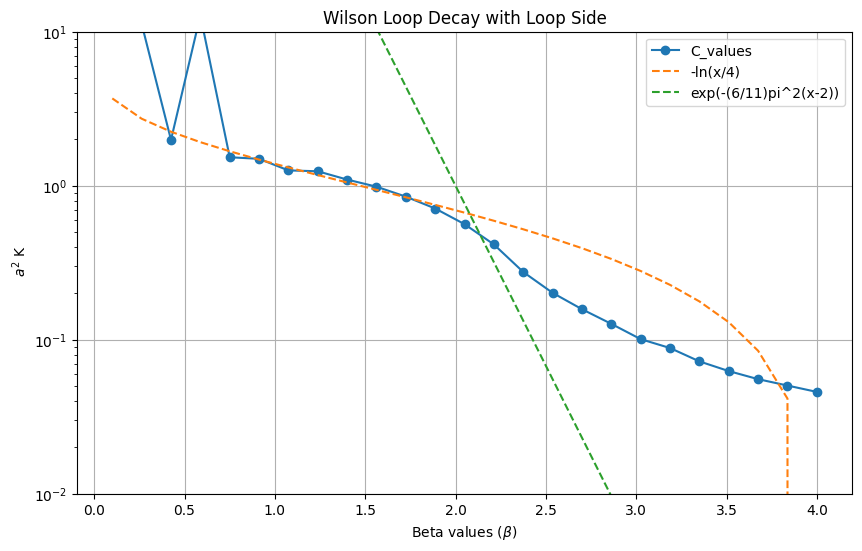

In [ ]:
from scipy.optimize import curve_fit

# Function to compute Wilson loop values based on the given formula
def wilson_loop_formula(S, A, B, C):
    S=np.array(S)
    return np.exp(-(+B*S+C * S**2))

mean_wilson_values={1: [0.025325392772154582, 0.06588538604501096, 0.1067231666169877, 0.1444435537109859, 0.18218054961642138, 0.22342968975948385, 0.2597691987689263, 0.29883704024046753, 0.3384433956133165, 0.37793551936721087, 0.4208829289699584, 0.46652237048217177, 0.5186980800054803, 0.5726932155121806, 0.6253080783877343, 0.6581299421630231, 0.684498857651287, 0.7069876619747312, 0.7247578556641205, 0.7408733366091089, 0.7553971073892864, 0.7686115323264954, 0.7805169996398655, 0.7907067499997028, 0.7997924413852366],
                    2: [-0.0015091757593887164, -0.0010878504393149104, 0.00021503135341893569, -0.0009160233420421769, 0.0015530617730870279, 0.0025122769080977787, 0.005453719263838225, 0.007456461370503657, 0.012804182106562262, 0.01990470600712647, 0.03237261065584768, 0.05250988515171094, 0.0872485214563542, 0.14063545592685583, 0.2159237154622975, 0.2683997355303872, 0.3110734982972692, 0.3498383338293326, 0.38093114636883163, 0.4116959362532878, 0.4381533972142808, 0.46308588077034846, 0.48644466112842827, 0.506496911596878, 0.5235356800995643],
                    3: [8.242191364646079e-05, -0.0004571447149867294, 3.55290018814356e-05, 4.8755262348371193e-05, 0.00034369165373177935, -0.0009908682125781762, 0.0005822185767757565, 0.0009108925340830087, -0.0009167935726170125, -0.0002469903389006665, 0.0011752843117499951, 0.0010033304396733713, 0.005104056185445177, 0.02150625204274937, 0.05676932673289283, 0.09334420167973886, 0.12426753445831759, 0.15503890040067186, 0.18511551158600525, 0.21142395333304714, 0.23899737454289624, 0.26484386132871, 0.2885230470755832, 0.3095427091510074, 0.32846422269739955],
                    4: [0.0004980767656675401, 0.0004365027269782576, 0.0007287103269675634, 0.0012251381593672956, -3.48586146557302e-06, -5.488782743848287e-05, 0.00012974043423909047, 6.883982029980125e-05, 0.00043080120848148834, -0.00012005463665996064, -0.0004608476674161473, 0.00047391941367469736, 0.000714064065973722, 0.0025928084467633536, 0.012313668415431318, 0.02904575512136075, 0.048544843716548616, 0.06775168549937666, 0.09016686449840981, 0.1057325259791692, 0.13061120815162006, 0.15131427441031783, 0.16944789803833968, 0.1879218443009178, 0.20484868818756716],
                    5: [0.00035111299705438333, -0.0007797594837026107, -0.00023960177941616934, 0.00039447502665439053, 0.0005934340070051525, -0.0001756975446253049, 0.0002354433084785861, 0.00018506728046362237, 0.0007953576624440848, 0.0007255367169702023, 0.0007468729545425109, -6.473157932599793e-06, 0.001454647307976983, 0.0008828207624891448, 0.0013492487943892989, 0.01184997655677379, 0.020840245096791075, 0.030632489269796864, 0.04557691207750171, 0.05503784215944594, 0.07230103744090828, 0.08739999645989249, 0.10427850309178673, 0.11716177913228457, 0.13186037814112012]
                    }

# Loop side values (S)
loop_sizes = [1, 2, 3, 4, 5]

# Beta values
beta_values = np.linspace(0.1, 4.0, 25)

# Perform fitting and plotting for each beta
C_values = []  # Store C values for each beta

plt.figure(figsize=(10, 6))

for beta_index, beta in enumerate(beta_values):
    # Extract Wilson loop values for the current beta
    wilson_values_for_beta = [mean_wilson_values[loop_size][beta_index]
                              for loop_size in loop_sizes]

    #print(beta,wilson_values_for_beta)

    # Fit the data to the formula
    popt, _ = curve_fit(wilson_loop_formula, loop_sizes, wilson_values_for_beta)
    A_fit, B_fit, C_fit = popt
    C_values.append(C_fit)

    # Plot the original data and the fitted curve
    #plt.plot(loop_sizes, wilson_values_for_beta, marker='o', linestyle='-',
             #label=f'Beta = {beta:.2f} (Data)')
    #plt.plot(loop_sizes, wilson_loop_formula(loop_sizes, A_fit, B_fit, C_fit),
             #linestyle='--', label=f'Beta = {beta:.2f} (Fit)')

#print(C_values)

# Define the functions
def func1(x):
  return -np.log(x / 4)

def func2(x):
  return np.exp(-(6 / 11) * np.pi**2 * (x - 2))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(beta_values, C_values, marker='o', linestyle='-', label='C_values')
plt.plot(beta_values, func1(np.array(beta_values)), linestyle='--', label='-ln(x/4)')
plt.plot(beta_values, func2(np.array(beta_values)), linestyle='--', label='exp(-(6/11)pi^2(x-2))')

# Set logarithmic y-axis
plt.yscale("log")

# Add labels, title, legend, and grid
plt.xlabel("Beta values ($ \\beta$)")
plt.ylabel(" $a^2$ K" )
plt.ylim(10**(-2),10)
plt.title("Wilson Loop Decay with Loop Side")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:

# Define the functions
def func1(x):
  return -np.log(x / 4)

def func2(x):
  return np.exp(-(6 / 11) * np.pi**2 * (x - 2))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(beta_values, C_values, marker='o', linestyle='-', label='C_values')
plt.plot(beta_values, func1(np.array(beta_values)), linestyle='--', label='-ln(x/4)')
plt.plot(beta_values, func2(np.array(beta_values)), linestyle='--', label='exp(-(6/11)pi^2(x-2))')

# Set y-axis to log scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Beta Values')
plt.ylabel('C Values')
plt.title('C Values vs Beta Values')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Extras

## Interpretation

#
Key Physical Observables

  - Wilson Loop:
        
      - Purpose: The Wilson loop is a crucial quantity for understanding confinement. It is defined as the trace of the path-ordered product of gauge links around a closed loop on the lattice.
        
      - Interpretation: The expectation value of the Wilson loop, ⟨W(C)⟩⟨W(C)⟩, decays exponentially with the area enclosed by the loop if quarks are confined. This behavior signifies a "string tension" between static quarks, which can be computed to quantify confinement.

  - String Tension (σσ):
      
      - Purpose: The string tension characterizes the energy per unit length of the flux tube between a quark-antiquark pair.
      
      - Calculation: By measuring the potential between a quark-antiquark pair as a function of separation distance, you can extract the string tension from the linear rise in the potential at large distances.
        
      - Confinement: A non-zero string tension indicates confinement, while a vanishing string tension suggests a deconfined phase.

  - Polyakov Loop:
        
      - Purpose: The Polyakov loop is useful for studying finite temperature behavior and phase transitions. It measures the free energy of a single static quark.
        
      - Interpretation: The expectation value of the Polyakov loop vanishes in the confined phase (indicating infinite free energy for an isolated quark) and becomes non-zero in the deconfined phase, signaling a phase transition.

  - Correlation Functions:
      
      - Purpose: To study how fields or observables are correlated over spacetime distances.
      
      - Interpretation: The decay of correlation functions as a function of distance provides information about the mass gap and the behavior of glueballs (bound states of gluons).

  - Running Coupling and Asymptotic Freedom:
        
      - Purpose: By studying the behavior of the gauge coupling at different scales, you can observe the logarithmic decrease in the coupling strength at high energies, consistent with asymptotic freedom.
        
      - Renormalization: Comparing your results to the predictions of the renormalization group equations helps validate asymptotic freedom in your SU(2) theory.
    


In [ ]:
def polyakov_loop(U):
    total_value = 0.0
    for x in range(L):
        for y in range(L):
            for z in range(L):
                P = np.eye(2, dtype=complex)
                for t in range(L):
                    P = P @ U[x, y, z, t, 3]  # Temporal direction
                total_value += np.real(np.trace(P))
    return total_value / (L ** 3)

# Example usage
polyakov_value = polyakov_loop(U)
print("Polyakov Loop Value:", polyakov_value)


The Polyakov loop is used to study finite temperature effects and can be added as another observable in your simulation. It measures the free energy of a static quark in a heat bath and is useful for identifying deconfinement.


# Test Functions

In [ ]:
################### TEST hot initialization ###########################

def check_su2_properties(num_samples=100000):
    """
    Verify that the Hot_Initialization function generates valid SU(2) matrices.
    Checks unitarity (U†U = I) and determinant condition (det(U) = 1).
    """
    errors = 0
    det_errors = 0

    for _ in range(num_samples):
        U = Hot_Initialization()

        # Check unitarity: U†U should be identity
        unitarity_check = np.allclose(U.conj().T @ U, np.eye(2), atol=1e-10)

        # Check determinant: det(U) should be 1
        det_check = np.isclose(np.linalg.det(U), 1.0, atol=1e-10)

        if not unitarity_check:
            errors += 1
        if not det_check:
            det_errors += 1

    print(f"Total matrices checked: {num_samples}")
    print(f"Unitarity violations: {errors}")
    print(f"Determinant violations: {det_errors}")

    if errors == 0 and det_errors == 0:
        print("✅ Hot Initialization is correctly generating SU(2) matrices.")
    else:
        print("❌ Errors detected. The initialization may be incorrect.")

# Run the test
check_su2_properties()


In [ ]:
################### TEST a_0 distribution ###########################

from scipy.optimize import curve_fit

# Exponential function for fitting
def expected_distribution(a_0, c, beta, K):
    return c * np.sqrt(1 - a_0**2) * np.exp( beta * K * a_0)

def test_a0_distribution(U):
    """
    Test whether the sampled a_0 values follow the expected probability distribution.
    """
    L = 4
    beta = 2.3
    mu = 1
    x, y, z, t = 0, 0, 0, 0
    num_samples = 10000  # Large sample size

    a_0_samples = []
    K=5

    for _ in range(num_samples):
        a_0 = generate_a0(beta, K)
        a_0_samples.append(a_0)

    # Histogram of sampled values
    bins = 100
    hist_data, bin_edges = np.histogram(a_0_samples, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit sampled data with theoretical function
    popt, _ = curve_fit(lambda a_0, c: expected_distribution(a_0, c, beta, K),
                        bin_centers, hist_data, p0=[1])


    # Plot results
    plt.figure(figsize=(8, 5))
    plt.hist(a_0_samples, bins=bins, density=True, alpha=0.6, label="Sampled $a_0$ Histogram")

    # Plot theoretical curve
    a_0_range = np.linspace(min(a_0_samples), max(a_0_samples), 100)
    plt.plot(a_0_range, expected_distribution(a_0_range, popt[0], beta, K), 'r--', label="Expected Distribution")

    plt.xlabel("$a_0$")
    plt.ylabel("Probability Density")
    plt.title("Verification of $a_0$ Distribution in Heat Bath Sampling")
    plt.legend()
    plt.grid()
    plt.show()

# Run the test
# Initialize a unitary lattice
U = {mu: np.array([[[[np.eye(2, dtype=complex) for _ in range(L)]
                          for _ in range(L)] for _ in range(L)] for _ in range(L)])
         for mu in range(4)}

test_a0_distribution(U)



In [ ]:
################### TEST K,U_bar ###########################


# Identity Matrix Lattice (Cold Start)
L = 4  # Lattice size
U = {mu: np.array([[[[np.eye(2, dtype=complex) for _ in range(L)]
                      for _ in range(L)] for _ in range(L)] for _ in range(L)])
     for mu in range(4)}

x, y, z, t, mu = 1, 1, 1, 1, 2  # Random coordinate & direction

k, U_bar = compute_k(U, x, y, z, t, mu, L)
print("We expect k to be 6")
print(f"Staple sum k: {k}")
print(f"U_bar:\n{U_bar}")
wall()


# Initialize lattice with random SU(2) elements
U = {mu: np.array([[[[Hot_Initialization() for _ in range(L)]
                      for _ in range(L)] for _ in range(L)] for _ in range(L)])
     for mu in range(4)}

k, U_bar = compute_k(U, x, y, z, t, mu, L)
print("We expect k to be typically in the range [3,6]")
print(f"Staple sum k: {k}")
print(f"U_bar:\n{U_bar}")


In [ ]:
################### TEST forward-backward functions ###########################

def test_forward_backward():
    L = 4  # Define lattice size
    test_cases = [
        ((0, 0, 0, 0), 0),
        ((1, 2, 3, 1), 1),
        ((3, 3, 3, 3), 2),
        ((0, 1, 2, 3), 3),
        ((L-1, L-1, L-1, L-1), 0),  # Edge case at boundary
    ]

    for coord, direction in test_cases:
        forward_result = forward(coord, direction, L)
        backward_result = backward(forward_result, direction, L)
        assert backward_result == coord, f"Forward then backward failed at {coord}, dir {direction}"

        backward_result2 = backward(coord, direction, L)
        forward_result2 = forward(backward_result2, direction, L)
        assert forward_result2 == coord, f"Backward then forward failed at {coord}, dir {direction}"

    print("All tests passed!")

# Run the test
test_forward_backward()


All tests passed!


In [ ]:
################### TEST wilson loop ###########################

def test_wilson_loop():
    L = 4  # Lattice size
    loop_size = 1  # Plaquette (smallest loop)

    # Create a dictionary of identity matrices for all directions
    U = {mu: np.array([[[[np.eye(2, dtype=complex) for _ in range(L)]
                          for _ in range(L)] for _ in range(L)] for _ in range(L)])
         for mu in range(4)}

    expected_result = 1.0  # If all links are identity, Wilson loop should be 1.0
    computed_result = wilson_loop(U, loop_size, L)

    assert np.isclose(computed_result, expected_result, atol=1e-6), f"Test failed! Expected {expected_result}, got {computed_result}"

    print("Wilson loop test passed!")

# Run the test
test_wilson_loop()

import scipy.linalg

def test_wilson_loop_random():
    """
    Test the Wilson loop on a random SU(2) lattice.
    """
    L = 8
    loop_size = 1
    U={ mu: np.array([[[[Hot_Initialization() for _ in range(L)] for _ in range(L)] for _ in range(L)]for _ in range(L)])
                for mu in range(4)}

    wilson_value = wilson_loop(U, loop_size, L)

    print(f"Wilson Loop on Random SU(2) Lattice: {wilson_value}")

# Run the test
test_wilson_loop_random()

